# 趋势分析
* 高量
    * 倍量
        * 从过去一年的最低价开始找
        * 比前一天的成交量大于170%
        * 收盘价大于开盘价
    * 梯量
        * 至少后续两天每日比前日成交量上升10%以上
        * 每日收盘价一致大于或小于开盘价
* 缩量
    * 明天比今天成交量少或者一样，后天比明天少或者一样
* 平量
    * 今天和昨天的量一样或者相差1%以内
* 未补的跳空缺口
    * 上升缺口
        * 明日最低价高于今日最高价
    * 上升补口
        * 从“上升缺口”后任何日最低价低于等于“上升缺口”最高价
    * 未补上升缺口
        * 后续没有任何“上升补口”的“上升缺口”
    * 下降缺口
        * 明日最高价低于今日最低价
    * 下降补口
        * 从“下降缺口”后任何日最高价高于等于“下降缺口”最低价
    * 未补下降缺口
        * 后续没有任何“下降补口”的“下降缺口”

In [89]:
# Import dependencies
import math
import datetime
import pandas as pd
import numpy as np
import mplfinance as mpf
from pandas_datareader import data as pdr
from src.helpers import scope_dataframe, annotate_arrows, annotate_texts

In [153]:
now = datetime.datetime.now()
start = now - datetime.timedelta(days=365)
stock = pdr.get_data_yahoo('300081.SZ', start=start, end=now.date())

In [3]:
stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-16,5.32,5.02,5.25,5.05,10763080,5.05
2020-11-17,5.06,4.86,5.06,4.95,9013582,4.95
2020-11-18,5.11,4.90,4.92,4.99,8566494,4.99
2020-11-19,5.05,4.92,4.97,5.02,6323752,5.02
2020-11-20,5.18,4.95,5.03,4.99,7511652,4.99


## 倍量

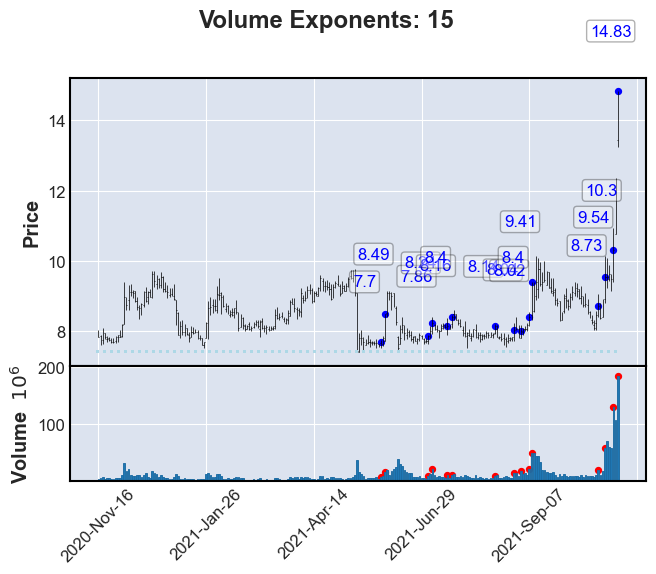

In [176]:
def exponent_trend(ticker=None, stock=pd.DataFrame(), growth_rate=1.7, time_range=365, show_graph=True):
    now = datetime.datetime.now()
    start = now - datetime.timedelta(days=time_range)
    if stock.empty:
        stock = pdr.get_data_yahoo(ticker, start=start, end=now.date())

    df, exponents, lowest = find_exponents(stock, growth_rate, time_range)

    if show_graph:
        # low_close = math.floor(lowest['Close'].values[0])
        graph_exponents(plot_exponents(df, ['Subplot1', 'Subplot2'], exponents), 
            lowest,
            f'Volume Exponents: {len(exponents)}')

def find_exponents(df, growth_rate, time_range):
    scoped_df = scope_dataframe(df, time_range)
    # Find lowest Close in time range.
    lowest = scoped_df[scoped_df['Close'] == scoped_df['Close'].min()]
    rebound = scoped_df.index > lowest.index[0]
    # Find each date where Volume is at least 1.7 of previous day.
    exponents = scoped_df.loc[rebound & (scoped_df['Volume'] >= scoped_df.shift(1)['Volume'] * growth_rate) & (scoped_df['Close'] >= scoped_df['Open'])]

    return scoped_df, exponents, lowest

def graph_exponents(df, lowest, title='Exponent Graph'):
    line = dict(hlines=lowest['Close'].values[0], colors=('lightblue'), linestyle='dotted')

    subplot = []
    if 'Subplot1' in df.columns:
        subplot.append(mpf.make_addplot(df['Subplot1'], type='scatter', color='b'))
        subplot.append(mpf.make_addplot(df['Subplot2'], type='scatter', panel=1,  color='r'))

    fig, axlist = mpf.plot(df, volume=True, hlines=line, addplot=subplot, title=title, returnfig=True)
    if 'Subplot1' in df.columns:
        annotate_texts(axlist[0], df['Subplot1'])

def plot_exponents(df, keys, exponents):
    if len(exponents) != 0:
        df[keys[0]] = exponents['Close']
        df[keys[1]] = exponents['Volume']
    return df
    
# exponent_trend(stock=stock)

## 梯量

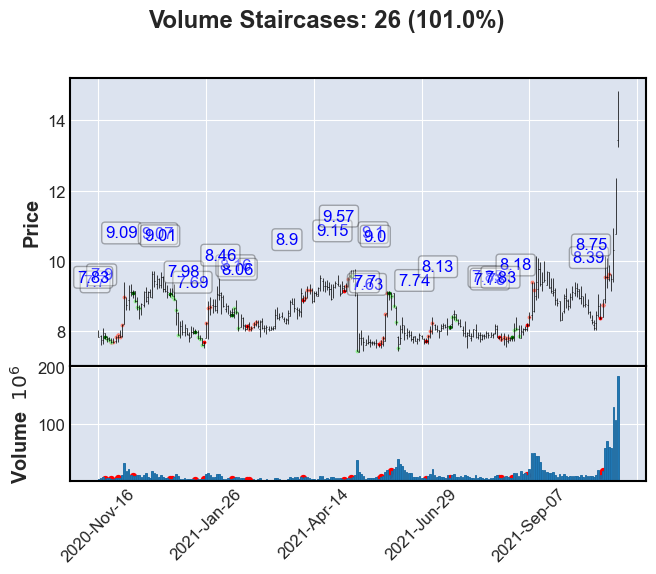

In [173]:
def staircase_trend(ticker=None, stock=pd.DataFrame(), growth_rate=1.01, time_range=365, show_graph=True):
    now = datetime.datetime.now()
    start = now - datetime.timedelta(days=time_range)
    if stock.empty:
        stock = pdr.get_data_yahoo(ticker, start=start, end=now.date())

    df, growth, rise, fall = find_staircases(stock, growth_rate, time_range)

    if show_graph:
        staircases = df[(growth & rise) | (growth & fall)]
        graph_staircases(plot_staircases(plot_staircases(df, ['Subplot1', 'Subplot2', 'Subplot3'], rise, growth), ['Subplot4', 'Subplot5', 'Subplot6'], fall, growth),
            f'Volume Staircases: {len(staircases)} ({growth_rate * 100}%)'
            )

def find_staircases(df, growth_rate, time_range):
    scoped_df = scope_dataframe(df, time_range)
    # Find at least 3 consecutive volume increase of .1 
    growth = (scoped_df.shift(1)['Volume'] >= scoped_df.shift(2)['Volume'] * growth_rate) & (scoped_df.shift(2)['Volume'] >= scoped_df.shift(3)['Volume'] * growth_rate)

    # Find consecutive price increase
    price_rise = (scoped_df['Open'] <= scoped_df['Close']) & (scoped_df.shift(1)['Open'] < scoped_df.shift(1)['Close'])
    # Find consecutive price decrease
    price_fall = (scoped_df['Open'] > scoped_df['Close']) & (scoped_df.shift(1)['Open'] > scoped_df.shift(1)['Close'])
    return scoped_df, growth, price_rise, price_fall

def graph_staircases(df, title='Staircases Graph'):
    subplot = []
    if len(df['Subplot1'][df['Subplot1'].notnull()]) != 0:
        subplot.append(mpf.make_addplot(df['Subplot1'], type='scatter', color='r', markersize=3))
        subplot.append(mpf.make_addplot(df['Subplot3'], type='scatter', panel=1, color='r'))

    if len(df['Subplot2'][df['Subplot2'].notnull()]) != 0:
        subplot.append(mpf.make_addplot(df['Subplot2'], type='scatter',color='salmon', markersize=3))

    if len(df['Subplot4'][df['Subplot4'].notnull()]) != 0:
        subplot.append(mpf.make_addplot(df['Subplot4'], type='scatter', color='g', markersize=3))
        subplot.append(mpf.make_addplot(df['Subplot6'], type='scatter', panel=1, color='r'))

    if len(df['Subplot5'][df['Subplot5'].notnull()]) != 0:
        subplot.append(mpf.make_addplot(df['Subplot5'], type='scatter',color='lightgreen', markersize=3))

    fig, axlist = mpf.plot(df, volume=True, addplot=subplot, title=title, returnfig=True)
    annotate_texts(axlist[0], df['Subplot1'])
    annotate_texts(axlist[0], df['Subplot4'])

def plot_staircases(df, keys, priceTrend, growth):
    df[keys[0]] = df['Close'][growth & priceTrend]
    df[keys[1]] = df['Close'][(df[keys[0]].notnull())
        | (df.shift(-1)[keys[0]].notnull())
        | (df.shift(-2)[keys[0]].notnull())]

    df[keys[2]] = df['Volume'][(df.shift(-3)[keys[0]].notnull())]
    df[keys[0]] = df['Close'][(df.shift(-3)[keys[0]].notnull())]
    return df

# staircase_trend(stock=stock)

## 缩量

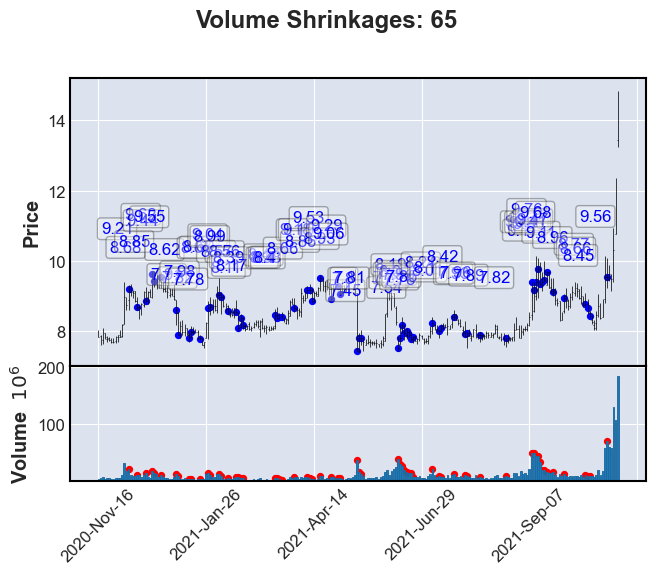

In [167]:
def shrinkage_trend(ticker=None, stock=pd.DataFrame(), time_range=365, show_graph=True):
    now = datetime.datetime.now()
    start = now - datetime.timedelta(days=time_range)
    if stock.empty:
        stock = pdr.get_data_yahoo(ticker, start=start, end=now.date())

    df, shrinkages = find_shrinkages(stock, time_range)

    if show_graph:
        graph_shrinkages(plot_shrinkages(df, ['Subplot1', 'Subplot2'], shrinkages), 
            f'Volume Shrinkages: {len(df[shrinkages == True])}')

def find_shrinkages(df, time_range):
    scoped_df = scope_dataframe(df, time_range)
    # Find 2 consecutive days where volume is greater than the next day.
    shrinkages = (scoped_df['Volume'] > scoped_df.shift(-1)['Volume']) & (scoped_df.shift(-1)['Volume'] > scoped_df.shift(-2)['Volume'])

    return df, shrinkages

def graph_shrinkages(df, title='Shrinkage Graph'):
    subplot = []
    if 'Subplot1' in df.columns:
        subplot.append(mpf.make_addplot(df['Subplot1'], type='scatter', color='b'))
        subplot.append(mpf.make_addplot(df['Subplot2'], type='scatter', panel=1,  color='r'))

    fig, axlist = mpf.plot(df, volume=True, addplot=subplot, title=title, returnfig=True)
    if 'Subplot1' in df.columns:
        annotate_texts(axlist[0], df['Subplot1'])

def plot_shrinkages(df, keys, shrinkages):
    if len(df[shrinkages]) != 0:
        df[keys[0]] = df[shrinkages]['Close']
        df[keys[1]] = df[shrinkages]['Volume']
    return df

# shrinkage_trend(stock=stock)

## 平量

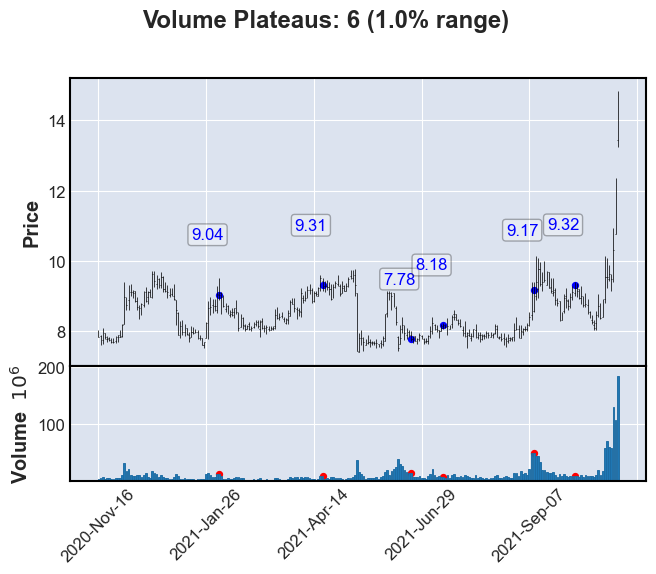

In [166]:
def plateau_trend(ticker=None, stock=pd.DataFrame(), volume_range=.01, time_range=365, show_graph=True):
    now = datetime.datetime.now()
    start = now - datetime.timedelta(days=time_range)
    if stock.empty:
        stock = pdr.get_data_yahoo(ticker, start=start, end=now.date())

    df, plateaus = find_plateaus(stock, volume_range, time_range)

    if show_graph:
        graph_plateaus(plot_plateaus(df, ['Subplot1', 'Subplot2'], plateaus), 
            f'Volume Plateaus: {len(df[plateaus == True])} ({volume_range * 100}% range)')

def find_plateaus(df, volume_range, time_range):
    scoped_df = scope_dataframe(df, time_range)
    # Find where volume is in 1.01 range of previous day
    u_bound = 1 - volume_range
    l_bound = 1 + volume_range
    plateaus = (scoped_df['Volume'] >= scoped_df.shift(1)['Volume'] * u_bound) & (scoped_df['Volume'] <= scoped_df.shift(1)['Volume'] * l_bound)

    return df, plateaus

def graph_plateaus(df, title='Plateaus Graph'):
    subplot = []
    if 'Subplot1' in df.columns:
        subplot.append(mpf.make_addplot(df['Subplot1'], type='scatter', color='b'))
        subplot.append(mpf.make_addplot(df['Subplot2'], type='scatter', panel=1,  color='r'))

    fig, axlist = mpf.plot(df, volume=True, addplot=subplot, title=title, returnfig=True)
    if 'Subplot1' in df.columns:
        annotate_texts(axlist[0], df['Subplot1'])

def plot_plateaus(df, keys, plateaus):
    if len(df[plateaus]) != 0:
        df[keys[0]] = df[plateaus]['Close']
        df[keys[1]] = df[plateaus]['Volume']
    return df

# plateau_trend(stock=stock)

## 跳空缺口

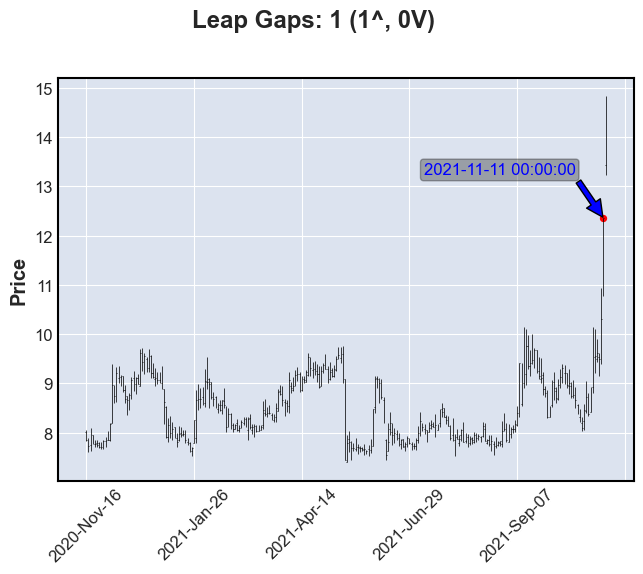

In [163]:
def leap_trend(ticker=None, stock=pd.DataFrame(), time_range=365, show_graph=True):
    now = datetime.datetime.now()
    start = now - datetime.timedelta(days=time_range)
    if stock.empty:
        stock = pdr.get_data_yahoo(ticker, start=start, end=now.date())

    df, rise, fall = find_leaps(stock, time_range)

    if show_graph:
        riseCount = len(rise['leaps'])
        fallCount = len(fall['leaps'])
        graph_leaps(plot_leaps(df, ['Subplot1', 'Subplot2'], rise['leaps'], fall['leaps']),
            # rise['leaps'],
            # fall['leaps'],
            f'Leap Gaps: {riseCount + fallCount} ({riseCount}^, {fallCount}V)')

def find_leaps(df, time_range):
    scoped_df = scope_dataframe(df, time_range)
    # Find where High is lower than next day Low
    rise_gaps = (scoped_df['High'] < scoped_df.shift(-1)['Low'])
    rise_gap_fillers = []
    rise_leaps = []
    for index, row in scoped_df[rise_gaps].iterrows():
        gap_filled = scoped_df[(scoped_df.index > index) & (scoped_df['Low'] <= row['High'])]
        # Find where Low is lower or equal to rise_gap High
        if gap_filled.empty == False:
            rise_gap_fillers.append(gap_filled.head(1))
        else:
            # Return the rise_gap if no gap was filled
            rise_leaps.append(scoped_df[scoped_df.index == index])

    # Find where Low is higher than next day High
    fall_gaps = (scoped_df['Low'] > scoped_df.shift(-1)['High'])
    fall_gap_fillers = []
    fall_leaps = []
    for index, row in scoped_df[fall_gaps].iterrows():
        # Find where High is higher or equal to fall_gap Low
        gap_filled = scoped_df[(scoped_df.index > index) & (scoped_df['High'] >= row['Low'])]
        if gap_filled.empty == False:
            fall_gap_fillers.append(gap_filled.head(1))
        else:
            # Return the fall_gap if no gap was filled
            fall_leaps.append(scoped_df[scoped_df.index == index])

    if len(rise_leaps) != 0:
        rise_leaps = pd.concat(rise_leaps)

    if len(fall_leaps) != 0:
        fall_leaps = pd.concat(fall_leaps)

    return scoped_df, dict(leaps=rise_leaps, gaps=rise_gaps, gap_fillers=rise_gap_fillers), dict(leaps=fall_leaps, gaps=fall_gaps, gap_fillers=fall_gap_fillers)

def graph_leaps(df, title='Leaps Graph'):
    subplot = []
    if 'Subplot1' in df.columns:
        subplot.append(mpf.make_addplot(df['Subplot1'], type='scatter', color='r'))

    if 'Subplot2' in df.columns:
        subplot.append(mpf.make_addplot(df['Subplot2'], type='scatter', color='g'))

    fig, axlist = mpf.plot(df, addplot=subplot, title=title, returnfig=True)
    
    if 'Subplot1' in df.columns:
        annotate_arrows(axlist[0], df['Subplot1'], df.index)

    if 'Subplot2' in df.columns:
        annotate_arrows(axlist[0], df['Subplot2'], df.index)

def plot_leaps(df, keys, rise_leaps, fall_leaps):
    if len(rise_leaps) != 0:
        df[keys[0]] = rise_leaps['Close']

    if len(fall_leaps) != 0:
        df[keys[1]] = fall_leaps['Close']

    return df

# leap_trend(stock=stock)

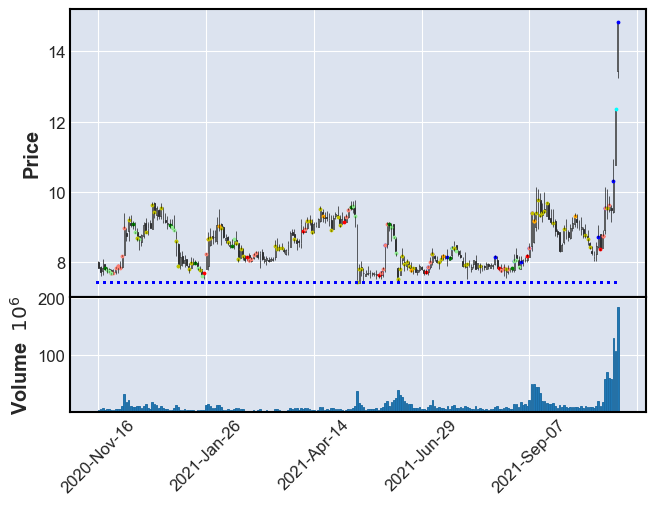

In [183]:
def aggregate_graph(df):
    df, exponents, lowest = find_exponents(stock, 1.7, 365)
    df, growth, s_rise, s_fall = find_staircases(stock, 1.01, 365)
    df, shrinkages = find_shrinkages(stock, 365)
    df, plateaus = find_plateaus(stock, .01, 365)
    df, l_rise, l_fall = find_leaps(stock, 365)

    df = plot_exponents(df, ['Expo1', 'Expo2'], exponents)
    df = plot_staircases(plot_staircases(df, ['StairR1', 'StairR2', 'StairR3'], s_rise, growth), ['StairF1', 'StairF2', 'StairF3'], s_fall, growth)
    df = plot_shrinkages(df, ['Shrink1', 'Shrink2'], shrinkages)
    df = plot_plateaus(df, ['Plat1', 'Plat2'], plateaus)
    df = plot_leaps(df, ['Leap1', 'Leap2'], l_rise['leaps'], l_fall['leaps'])

    line = dict(hlines=lowest['Close'].values[0], colors=('b'), linestyle='dotted')

    subplot = []
    # Exponent
    if 'Expo1' in df.columns:
        subplot.append(mpf.make_addplot(df['Expo1'], type='scatter', color='b', markersize=3))

    # Staircase
    if len(df['StairR1'][df['StairR1'].notnull()]) != 0:
        subplot.append(mpf.make_addplot(df['StairR1'], type='scatter', color='r', markersize=3))

    if len(df['StairR2'][df['StairR2'].notnull()]) != 0:
        subplot.append(mpf.make_addplot(df['StairR2'], type='scatter',color='salmon', markersize=3))

    if len(df['StairF1'][df['StairF1'].notnull()]) != 0:
        subplot.append(mpf.make_addplot(df['StairF1'], type='scatter', color='g', markersize=3))

    if len(df['StairF2'][df['StairF2'].notnull()]) != 0:
        subplot.append(mpf.make_addplot(df['StairF2'], type='scatter',color='lightgreen', markersize=3))

    # Shrinkage
    if 'Shrink1' in df.columns:
        subplot.append(mpf.make_addplot(df['Shrink1'], type='scatter', color='y', markersize=3))

    # Plateau
    if 'Plat1' in df.columns:
        subplot.append(mpf.make_addplot(df['Plat1'], type='scatter', color='orange', markersize=3))

    # Leap
    if 'Leap1' in df.columns:
        subplot.append(mpf.make_addplot(df['Leap1'], type='scatter', color='cyan', markersize=3))

    if 'Leap2' in df.columns:
        subplot.append(mpf.make_addplot(df['Leap2'], type='scatter', color='lime', markersize=3))

    fig, axlist = mpf.plot(df, type='candle', volume=True, hlines=line, addplot=subplot, returnfig=True)

aggregate_graph(stock)